# Lab 04 — Machine Learning Fundamentals

**학습 목표:**
1. 3가지 학습 유형 — Supervised / Unsupervised / Reinforcement Learning
2. 데이터 파이프라인 — 수집, 전처리, Train/Val/Test 분할
3. 손실 함수와 최적화 기초
4. PyTorch `Dataset` & `DataLoader` 구현

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import platform
# Handle minus signs and set font based on OS
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin': # macOS
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    # Requires installing a Korean font (e.g., Nanum) for Linux/Colab
    print("Hangul font setting needed")
plt.tight_layout()

# # ── 한글 폰트 설정 (macOS) ──────────────────────────────
# plt.rcParams["font.family"] = "AppleGothic"
# plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지
# # ────────────────────────────────────────────────────────

# sns.set_theme(style="whitegrid")
# rng = np.random.default_rng(42)

# print("PyTorch version:", torch.__version__)
# print("한글 폰트 :", plt.rcParams["font.family"])

<Figure size 640x480 with 0 Axes>

---
## Part 1. 3가지 학습 유형

| 유형 | 학습 신호 | 대표 문제 |
|---|---|---|
| **Supervised** | 정답 레이블 (y) 있음 | 분류, 회귀 |
| **Unsupervised** | 정답 레이블 없음 | 클러스터링, 차원 축소 |
| **Reinforcement** | 행동에 대한 보상 (Reward) | 게임, 로봇 제어 |

### 1-1. Supervised Learning — 분류

레이블이 있는 데이터로 **입력 → 출력 매핑**을 학습합니다.

In [11]:
iris = load_iris(as_frame=True)
X, y = iris.data.values, iris.target.values

# 학습 / 테스트 분할 후 분류
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
print(f"테스트 정확도: {accuracy_score(y_test, y_pred):.4f}")

테스트 정확도: 1.0000


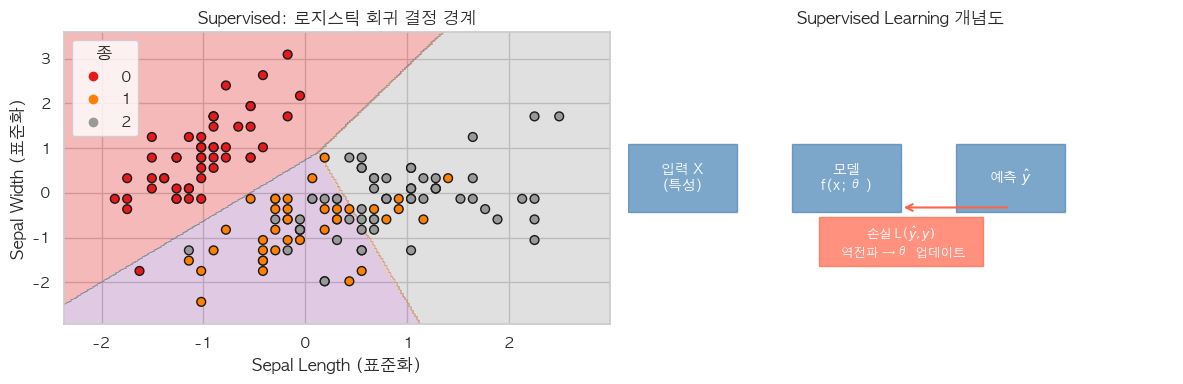

In [20]:
# 결정 경계 시각화 (2개 특성 사용)
X2 = X[:, :2]   # sepal length, sepal width
X2_s = StandardScaler().fit_transform(X2)
clf2 = LogisticRegression(max_iter=1000).fit(X2_s, y)

h = 0.02
x_min, x_max = X2_s[:, 0].min() - 0.5, X2_s[:, 0].max() + 0.5
y_min, y_max = X2_s[:, 1].min() - 0.5, X2_s[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 결정 경계
axes[0].contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
scatter = axes[0].scatter(X2_s[:, 0], X2_s[:, 1], c=y, cmap="Set1", edgecolors="k", s=40)
axes[0].set_title("Supervised: 로지스틱 회귀 결정 경계")
axes[0].set_xlabel("Sepal Length (표준화)")
axes[0].set_ylabel("Sepal Width (표준화)")
legend = axes[0].legend(*scatter.legend_elements(), title="종")

# 학습 과정 개념도
axes[1].set_xlim(0, 10); axes[1].set_ylim(0, 6); axes[1].axis('off')
boxes = [(1, 3, '입력 X\n(특성)'), (4, 3, '모델\nf(x; θ)'), (7, 3, '예측 $\hat{y}$')]
for bx, by, label in boxes:
    axes[1].add_patch(plt.Rectangle((bx-1, by-0.7), 2, 1.4, color='steelblue', alpha=0.7))
    axes[1].text(bx, by, label, ha='center', va='center', fontsize=10, color='white', fontweight='bold')
axes[1].annotate('', xy=(3, 3.35), xytext=(2, 3.35), arrowprops=dict(arrowstyle='->', lw=2))
axes[1].annotate('', xy=(6, 3.35), xytext=(5, 3.35), arrowprops=dict(arrowstyle='->', lw=2))
axes[1].annotate('', xy=(5, 2.4), xytext=(7, 2.4), arrowprops=dict(arrowstyle='->', lw=1.5, color='tomato'))
axes[1].add_patch(plt.Rectangle((3.5, 1.2), 3, 1, color='tomato', alpha=0.7))
axes[1].text(5, 1.7, '손실 L($\hat{y},y)$ \n 역전파 → θ 업데이트', ha='center', va='center', fontsize=9, color='white')
axes[1].set_title("Supervised Learning 개념도")

plt.tight_layout()
plt.show()

### 1-2. Unsupervised Learning — 클러스터링

레이블 **없이** 데이터의 내재된 구조를 발견합니다.

In [ ]:
# 레이블 제거 후 클러스터링 (K-Means)
X_no_label = X2_s.copy()   # 레이블 y는 사용하지 않음

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_no_label)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 클러스터 결과
axes[0].scatter(X_no_label[:, 0], X_no_label[:, 1],
                c=cluster_labels, cmap="Set2", edgecolors="k", s=40)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                marker="X", s=200, color="red", label="중심점 (centroid)", zorder=5)
axes[0].set_title("Unsupervised: K-Means 클러스터링 (k=3)")
axes[0].set_xlabel("Sepal Length (표준화)")
axes[0].set_ylabel("Sepal Width (표준화)")
axes[0].legend()

# 실제 정답 vs 클러스터 비교
axes[1].scatter(X_no_label[:, 0], X_no_label[:, 1],
                c=y, cmap="Set1", edgecolors="k", s=40)
axes[1].set_title("실제 정답 레이블 (비교용)")
axes[1].set_xlabel("Sepal Length (표준화)")
axes[1].set_ylabel("Sepal Width (표준화)")

plt.suptitle("K-Means는 레이블 없이도 비슷한 그룹을 발견", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Elbow Method — 최적 k 탐색
inertias = []
K_range = range(1, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_no_label)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, "o-", color="steelblue")
plt.axvline(3, color="red", linestyle="--", label="k=3 (elbow)")
plt.title("Elbow Method — 최적 k 선택")
plt.xlabel("클러스터 수 k")
plt.ylabel("Inertia (군집 내 분산)")
plt.legend()
plt.tight_layout()
plt.show()

### 1-3. Reinforcement Learning — Q-Learning (Grid World)

에이전트가 **환경과 상호작용**하며 보상을 최대화하는 정책을 학습합니다.

```
┌───┬───┬───┬───┐
│ S │   │   │   │   S = Start (시작)
├───┼───┼───┼───┤   G = Goal  (+1 보상)
│   │ ■ │   │   │   ■ = Hole  (-1 보상)
├───┼───┼───┼───┤
│   │   │   │ G │
└───┴───┴───┴───┘
```

In [21]:
# 4x4 Grid World Q-Learning
GRID  = 4
N_STATES  = GRID * GRID           # 16개 상태
N_ACTIONS = 4                      # 상, 하, 좌, 우
GOAL  = 15                         # (3,3)
HOLES = {5}                        # (1,1) — 함정
START = 0

def step(state, action):
    """행동을 취하고 (next_state, reward, done) 반환."""
    row, col = divmod(state, GRID)
    dr, dc = [(-1,0),(1,0),(0,-1),(0,1)][action]  # 상하좌우
    nr, nc = max(0, min(GRID-1, row+dr)), max(0, min(GRID-1, col+dc))
    ns = nr * GRID + nc
    if ns in HOLES:  return ns, -1.0, True
    if ns == GOAL:   return ns, +1.0, True
    return ns, -0.01, False       # 매 스텝 소량 패널티

# Q-Table 학습
Q = np.zeros((N_STATES, N_ACTIONS))
LR, GAMMA, EPS = 0.1, 0.99, 1.0
rewards_per_ep = []

for ep in range(2000):
    state = START; total_r = 0
    for _ in range(100):
        # ε-greedy 탐색
        action = (rng.integers(N_ACTIONS) if rng.random() < EPS
                  else Q[state].argmax())
        ns, r, done = step(state, action)
        # Bellman 업데이트
        Q[state, action] += LR * (r + GAMMA * Q[ns].max() - Q[state, action])
        state = ns; total_r += r
        if done: break
    EPS = max(0.01, EPS * 0.995)   # 탐색률 감소
    rewards_per_ep.append(total_r)

print("학습 완료")
print("최종 Q-Table (각 상태의 최적 행동값):")
print(Q.round(3))

학습 완료
최종 Q-Table (각 상태의 최적 행동값):
[[ 0.841  0.902  0.848  0.467]
 [ 0.107 -0.911  0.282  0.683]
 [ 0.072  0.872  0.027  0.008]
 [ 0.001  0.16  -0.008 -0.003]
 [ 0.862  0.921  0.87  -0.999]
 [ 0.     0.     0.     0.   ]
 [ 0.153  0.959 -0.833  0.235]
 [ 0.015  0.577  0.239  0.006]
 [ 0.839  0.604  0.899  0.941]
 [-0.975  0.863  0.882  0.96 ]
 [ 0.914  0.98   0.887  0.932]
 [ 0.129  0.992  0.362  0.302]
 [ 0.441  0.054  0.16   0.83 ]
 [ 0.3    0.118  0.173  0.98 ]
 [ 0.921  0.963  0.907  1.   ]
 [ 0.     0.     0.     0.   ]]


/var/folders/hh/w5xjnck119d_h0x6gxztgrwr0000gn/T/ipykernel_44798/1842722538.py:34: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axes[2].add_patch(plt.Rectangle((c, r), 1, 1, color=color, alpha=0.6, lw=0.5, edgecolor='gray'))


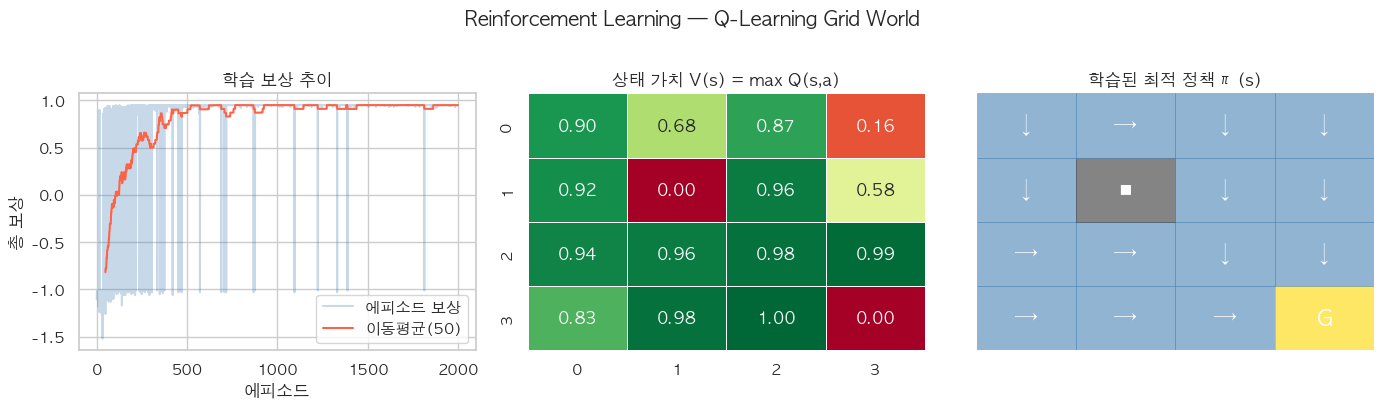

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 학습 보상 추이
window = 50
smoothed = pd.Series(rewards_per_ep).rolling(window).mean()
axes[0].plot(rewards_per_ep, alpha=0.3, color="steelblue", label="에피소드 보상")
axes[0].plot(smoothed, color="tomato", label=f"이동평균({window})")
axes[0].set_title("학습 보상 추이")
axes[0].set_xlabel("에피소드")
axes[0].set_ylabel("총 보상")
axes[0].legend()

# Q-Value 히트맵 (최대 Q값)
V = Q.max(axis=1).reshape(GRID, GRID)
sns.heatmap(V, annot=True, fmt=".2f", cmap="RdYlGn",
            ax=axes[1], cbar=False, linewidths=0.5)
axes[1].set_title("상태 가치 V(s) = max Q(s,a)")

# 최적 정책 시각화
arrows = ["↑", "↓", "←", "→"]
policy_grid = np.full((GRID, GRID), "", dtype=object)
for s in range(N_STATES):
    r, c = divmod(s, GRID)
    if s == GOAL:       policy_grid[r, c] = "G"
    elif s in HOLES:    policy_grid[r, c] = "■"
    else:               policy_grid[r, c] = arrows[Q[s].argmax()]

axes[2].set_xlim(0, GRID); axes[2].set_ylim(0, GRID); axes[2].axis('off')
for r in range(GRID):
    for c in range(GRID):
        symbol = policy_grid[GRID-1-r, c]
        color  = ("gold" if symbol=="G" else
                  "#333" if symbol=="■" else "steelblue")
        axes[2].add_patch(plt.Rectangle((c, r), 1, 1, color=color, alpha=0.6, lw=0.5, edgecolor='gray'))
        axes[2].text(c+0.5, r+0.5, symbol, ha='center', va='center',
                     fontsize=16, color='white', fontweight='bold')
axes[2].set_title("학습된 최적 정책 π(s)")

plt.suptitle("Reinforcement Learning — Q-Learning Grid World", y=1.02)
plt.tight_layout()
plt.show()

---
## Part 2. 데이터 파이프라인

```
원시 데이터 → 탐색(EDA) → 전처리 → Train/Val/Test 분할 → 모델 학습
```

### 2-1. 데이터 수집 및 탐색

In [23]:
wine = load_wine(as_frame=True)
df   = wine.frame.copy()
df["target_name"] = df["target"].map(dict(enumerate(wine.target_names)))

print("형태:", df.shape)
print("클래스 분포:")
print(df["target_name"].value_counts())
df.describe().round(2)

형태: (178, 15)
클래스 분포:
target_name
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89,0.94
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91,0.78
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00,0.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50,0.00
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50,1.00
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00,2.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00,2.00


결측치 합계: 0
중복 행 수 : 0


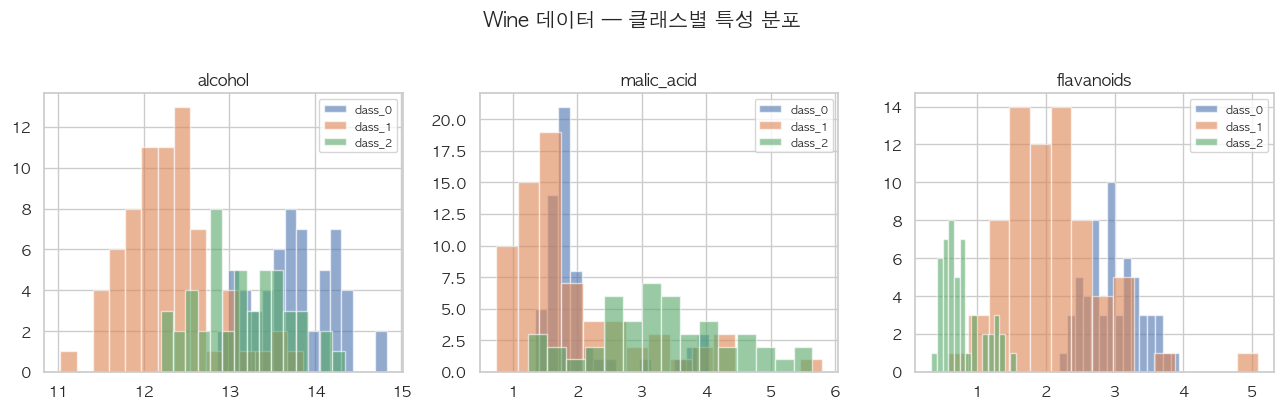

In [24]:
# 결측치 & 중복 확인
print("결측치 합계:", df.isnull().sum().sum())
print("중복 행 수 :", df.duplicated().sum())

# 클래스별 주요 특성 분포
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
features = ["alcohol", "malic_acid", "flavanoids"]
for ax, feat in zip(axes, features):
    for name, grp in df.groupby("target_name"):
        ax.hist(grp[feat], bins=15, alpha=0.6, label=name)
    ax.set_title(feat)
    ax.legend(fontsize=8)
plt.suptitle("Wine 데이터 — 클래스별 특성 분포", y=1.02)
plt.tight_layout()
plt.show()

### 2-2. 전처리

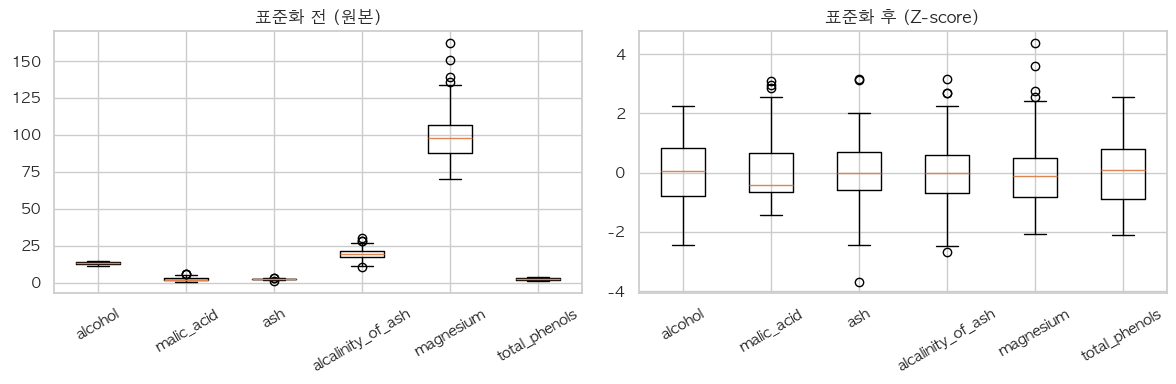

In [26]:
feature_cols = [c for c in df.columns if c not in ["target", "target_name"]]
X_raw = df[feature_cols].values.astype(np.float32)
y_raw = df["target"].values

# 표준화 전/후 비교
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].boxplot(X_raw[:, :6], tick_labels=feature_cols[:6])
axes[0].set_title("표준화 전 (원본)")
axes[0].tick_params(axis='x', rotation=30)
axes[1].boxplot(X_scaled[:, :6], tick_labels=feature_cols[:6])
axes[1].set_title("표준화 후 (Z-score)")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

### 2-3. Train / Val / Test 분할

Train :  106개  (60%)
Val   :   36개  (20%)
Test  :   36개  (20%)


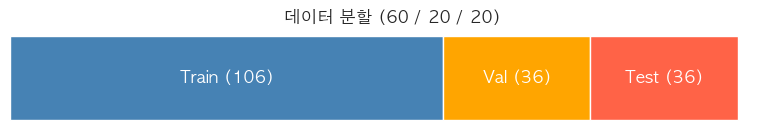

In [27]:
# 60% train / 20% val / 20% test
X_tv, X_test, y_tv, y_test = train_test_split(
    X_scaled, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tv, y_tv, test_size=0.25, stratify=y_tv, random_state=42   # 0.25 × 0.8 = 0.2
)

print(f"Train : {X_train.shape[0]:>4}개  ({X_train.shape[0]/len(X_raw)*100:.0f}%)")
print(f"Val   : {X_val.shape[0]:>4}개  ({X_val.shape[0]/len(X_raw)*100:.0f}%)")
print(f"Test  : {X_test.shape[0]:>4}개  ({X_test.shape[0]/len(X_raw)*100:.0f}%)")

# 분할 비율 시각화
fig, ax = plt.subplots(figsize=(8, 1.5))
sizes = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
colors = ["steelblue", "orange", "tomato"]
labels = [f"Train ({sizes[0]})", f"Val ({sizes[1]})", f"Test ({sizes[2]})"]
left = 0
for s, c, l in zip(sizes, colors, labels):
    ax.barh(0, s, left=left, color=c, edgecolor="white", height=0.6)
    ax.text(left + s/2, 0, l, ha="center", va="center", color="white", fontweight="bold")
    left += s
ax.axis("off")
ax.set_title("데이터 분할 (60 / 20 / 20)")
plt.tight_layout()
plt.show()

---
## Part 3. 손실 함수와 최적화 기초

### 3-1. 주요 손실 함수

In [28]:
# MSE (회귀용)
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

# Binary Cross-Entropy (이진 분류용)
def bce(y_true, y_prob):
    eps = 1e-9
    return -(y_true * np.log(y_prob + eps) + (1 - y_true) * np.log(1 - y_prob + eps)).mean()

# 예시
y_t  = np.array([1.0, 0.0, 1.0, 0.0])
good = np.array([0.9, 0.1, 0.8, 0.2])
bad  = np.array([0.4, 0.6, 0.3, 0.7])
print(f"좋은 예측 BCE: {bce(y_t, good):.4f}")
print(f"나쁜 예측 BCE: {bce(y_t, bad):.4f}")

# PyTorch 내장 손실 함수
mse_fn = nn.MSELoss()
ce_fn  = nn.CrossEntropyLoss()

pred_t = torch.tensor([[2.0, 0.5, 0.3], [0.1, 3.0, 0.2]])
true_t = torch.tensor([0, 1])           # 클래스 인덱스
print(f"\nCrossEntropyLoss: {ce_fn(pred_t, true_t).item():.4f}")

좋은 예측 BCE: 0.1643
나쁜 예측 BCE: 1.0601

CrossEntropyLoss: 0.2251


/var/folders/hh/w5xjnck119d_h0x6gxztgrwr0000gn/T/ipykernel_44798/1838601482.py:29: UserWarning: Glyph 375 (\N{LATIN SMALL LETTER Y WITH CIRCUMFLEX}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/pepc/Teaching/514/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 375 (\N{LATIN SMALL LETTER Y WITH CIRCUMFLEX}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


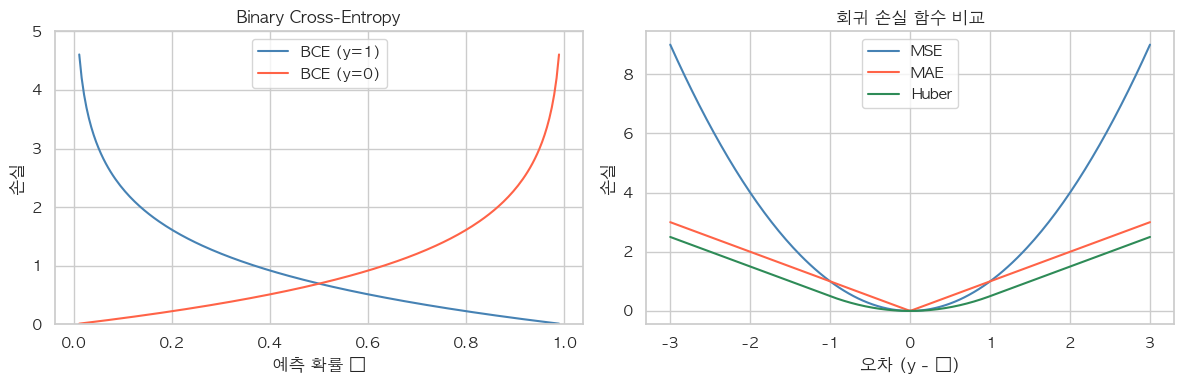

In [29]:
# 손실 함수 비교 시각화
y_hat = np.linspace(0.01, 0.99, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# BCE — y=1 vs y=0
axes[0].plot(y_hat, -np.log(y_hat),       label="BCE (y=1)", color="steelblue")
axes[0].plot(y_hat, -np.log(1 - y_hat),   label="BCE (y=0)", color="tomato")
axes[0].set_title("Binary Cross-Entropy")
axes[0].set_xlabel("예측 확률 ŷ")
axes[0].set_ylabel("손실")
axes[0].set_ylim(0, 5)
axes[0].legend()

# MSE vs MAE vs Huber
err = np.linspace(-3, 3, 200)
axes[1].plot(err, err**2,                        label="MSE",   color="steelblue")
axes[1].plot(err, np.abs(err),                   label="MAE",   color="tomato")
delta = 1.0
huber = np.where(np.abs(err) <= delta,
                 0.5 * err**2,
                 delta * (np.abs(err) - 0.5 * delta))
axes[1].plot(err, huber,                         label="Huber", color="seagreen")
axes[1].set_title("회귀 손실 함수 비교")
axes[1].set_xlabel("오차 (y - ŷ)")
axes[1].set_ylabel("손실")
axes[1].legend()

plt.tight_layout()
plt.show()

### 3-2. 경사 하강법 시각화

In [30]:
# y = 2x + 1 에 노이즈를 추가한 데이터로 선형 회귀
np.random.seed(0)
x_data = np.linspace(0, 5, 50)
y_data = 2.0 * x_data + 1.0 + np.random.randn(50) * 0.8

# w, b 를 파라미터로 경사 하강법
w, b   = 0.0, 0.0
lr     = 0.01
losses = []
history = [(w, b)]

for _ in range(200):
    y_pred = w * x_data + b
    loss   = ((y_pred - y_data) ** 2).mean()
    losses.append(loss)
    # 그래디언트
    dw = (2 * (y_pred - y_data) * x_data).mean()
    db = (2 * (y_pred - y_data)).mean()
    w -= lr * dw
    b -= lr * db
    if len(history) < 6:
        history.append((w, b))

print(f"학습된 w: {w:.4f}  (실제: 2.0)")
print(f"학습된 b: {b:.4f}  (실제: 1.0)")

학습된 w: 1.8972  (실제: 2.0)
학습된 b: 1.2743  (실제: 1.0)


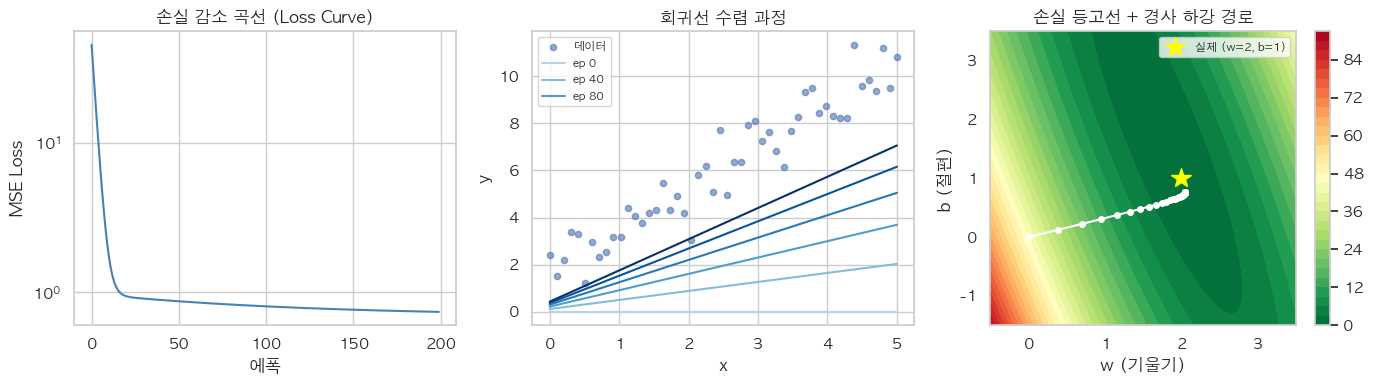

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 손실 감소 곡선
axes[0].plot(losses, color="steelblue")
axes[0].set_title("손실 감소 곡선 (Loss Curve)")
axes[0].set_xlabel("에폭")
axes[0].set_ylabel("MSE Loss")
axes[0].set_yscale("log")

# 회귀선 수렴 과정
axes[1].scatter(x_data, y_data, alpha=0.6, s=20, label="데이터")
colors_h = plt.cm.Blues(np.linspace(0.3, 1.0, len(history)))
for i, (wi, bi) in enumerate(history):
    x_line = np.array([0, 5])
    axes[1].plot(x_line, wi * x_line + bi, color=colors_h[i],
                 label=f"ep {i*40}" if i < 3 else None, lw=1.5)
axes[1].set_title("회귀선 수렴 과정")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].legend(fontsize=8)

# 손실 등고선과 경사 하강 경로
W_range = np.linspace(-0.5, 3.5, 100)
B_range = np.linspace(-1.5, 3.5, 100)
WW, BB  = np.meshgrid(W_range, B_range)
LL = np.array([[(wi * x_data + bi - y_data)**2 for wi, bi in zip(W_row, B_row)]
               for W_row, B_row in zip(WW, BB)]).mean(axis=-1)

cs = axes[2].contourf(WW, BB, LL, levels=30, cmap="RdYlGn_r")
plt.colorbar(cs, ax=axes[2])
w_hist, b_hist = [0.0], [0.0]
wt, bt = 0.0, 0.0
for _ in range(30):
    yp = wt * x_data + bt
    wt -= lr * (2 * (yp - y_data) * x_data).mean()
    bt -= lr * (2 * (yp - y_data)).mean()
    w_hist.append(wt); b_hist.append(bt)
axes[2].plot(w_hist, b_hist, "o-", color="white", markersize=4, lw=1.5)
axes[2].plot(2.0, 1.0, "*", color="yellow", markersize=15, label="실제 (w=2, b=1)")
axes[2].set_title("손실 등고선 + 경사 하강 경로")
axes[2].set_xlabel("w (기울기)")
axes[2].set_ylabel("b (절편)")
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

---
## Part 4. PyTorch `Dataset` & `DataLoader`

### 4-1. TensorDataset — 가장 간단한 방법

In [32]:
# numpy → torch tensor
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)

dataset    = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"데이터셋 크기: {len(dataset)}")
print(f"배치 수      : {len(dataloader)}")

# 첫 번째 배치 확인
X_batch, y_batch = next(iter(dataloader))
print(f"\n첫 배치 X: {X_batch.shape}")
print(f"첫 배치 y: {y_batch.shape}  →  {y_batch}")

데이터셋 크기: 106
배치 수      : 7

첫 배치 X: torch.Size([16, 13])
첫 배치 y: torch.Size([16])  →  tensor([1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1])


### 4-2. 커스텀 `Dataset` 구현

`Dataset`을 상속받아 `__len__`과 `__getitem__` 두 메서드를 구현하면 됩니다.

In [33]:
from typing import Optional, Callable

class WineDataset(Dataset):
    """Wine 분류 데이터셋 — transform 선택 적용 가능."""

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        transform: Optional[Callable] = None,
    ):
        # numpy → float32 tensor (feature)
        self.X = torch.tensor(X, dtype=torch.float32)
        # numpy → long tensor (label)
        self.y = torch.tensor(y, dtype=torch.long)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        x, label = self.X[idx], self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, label


# 데이터셋 생성
train_ds = WineDataset(X_train, y_train)
val_ds   = WineDataset(X_val,   y_val)
test_ds  = WineDataset(X_test,  y_test)

print(f"Train 데이터셋: {len(train_ds)}개")
print(f"Val   데이터셋: {len(val_ds)}개")
print(f"Test  데이터셋: {len(test_ds)}개")

x0, y0 = train_ds[0]
print(f"\n샘플 [0] — 특성 shape: {x0.shape}, 레이블: {y0.item()}")

Train 데이터셋: 106개
Val   데이터셋: 36개
Test  데이터셋: 36개

샘플 [0] — 특성 shape: torch.Size([13]), 레이블: 2


### 4-3. `DataLoader` — 배치 처리 & 셔플

In [34]:
BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train 배치 수: {len(train_loader)}  (batch_size={BATCH_SIZE})")
print(f"Val   배치 수: {len(val_loader)}")
print(f"Test  배치 수: {len(test_loader)}")

# 전체 배치 순회 예시
print("\n[ Train 배치 순회 ]")
for i, (xb, yb) in enumerate(train_loader):
    if i < 3:
        print(f"  batch {i}: X={xb.shape}, y={yb.shape}, 클래스={yb.tolist()}")
    else:
        print(f"  ... (총 {len(train_loader)}개 배치)")
        break

Train 배치 수: 7  (batch_size=16)
Val   배치 수: 3
Test  배치 수: 3

[ Train 배치 순회 ]
  batch 0: X=torch.Size([16, 13]), y=torch.Size([16]), 클래스=[2, 2, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
  batch 1: X=torch.Size([16, 13]), y=torch.Size([16]), 클래스=[1, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2, 1, 0, 0, 2]
  batch 2: X=torch.Size([16, 13]), y=torch.Size([16]), 클래스=[0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1]
  ... (총 7개 배치)


### 4-4. Transform — 온라인 데이터 증강

In [35]:
class AddGaussianNoise:
    """학습 시 가우시안 노이즈를 추가하는 transform (데이터 증강)."""
    def __init__(self, std: float = 0.05):
        self.std = std

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return x + torch.randn_like(x) * self.std


class Compose:
    """여러 transform을 순서대로 적용."""
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x


train_transform = Compose([
    AddGaussianNoise(std=0.05),
])

train_ds_aug = WineDataset(X_train, y_train, transform=train_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True)

# 원본 vs 증강 비교
x_orig, _ = train_ds[0]
x_aug,  _ = train_ds_aug[0]
print("원본 첫 5개 특성:", x_orig[:5].numpy().round(4))
print("증강 첫 5개 특성:", x_aug[:5].numpy().round(4))

원본 첫 5개 특성: [ 0.4439  0.2008 -0.0604  0.1517 -0.7542]
증강 첫 5개 특성: [ 0.4413  0.2293  0.0453  0.1422 -0.7897]


### 4-5. DataLoader를 활용한 미니 학습 루프

In [36]:
# 간단한 MLP 정의
class SimpleMLP(nn.Module):
    def __init__(self, in_features: int, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),
        )

    def forward(self, x):
        return self.net(x)


model     = SimpleMLP(in_features=13, n_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, val_accs = [], [], []

for epoch in range(50):
    # ── Train ──
    model.train()
    ep_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        ep_loss += loss.item() * len(xb)
    train_losses.append(ep_loss / len(train_ds))

    # ── Validation ──
    model.eval()
    with torch.no_grad():
        v_loss, correct = 0, 0
        for xb, yb in val_loader:
            logits = model(xb)
            v_loss  += criterion(logits, yb).item() * len(xb)
            correct += (logits.argmax(1) == yb).sum().item()
        val_losses.append(v_loss / len(val_ds))
        val_accs.append(correct / len(val_ds))

print(f"최종 Val Loss: {val_losses[-1]:.4f}  |  Val Acc: {val_accs[-1]:.4f}")

최종 Val Loss: 0.0373  |  Val Acc: 0.9722


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label="Train Loss", color="steelblue")
axes[0].plot(val_losses,   label="Val Loss",   color="tomato")
axes[0].set_title("학습 / 검증 손실")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(val_accs, color="seagreen")
axes[1].set_title("검증 정확도")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 테스트 성능
model.eval()
with torch.no_grad():
    correct = sum((model(xb).argmax(1) == yb).sum().item()
                  for xb, yb in test_loader)
print(f"\nTest Accuracy: {correct / len(test_ds):.4f}")

---
## Exercise

### Exercise 1. 커스텀 Dataset 구현

아래 `IrisDataset` 클래스를 완성하세요.  
- `__init__`: CSV 문자열 대신 numpy 배열을 받아 저장  
- `__len__`: 샘플 수 반환  
- `__getitem__`: idx번째 `(feature_tensor, label_tensor)` 반환

In [ ]:
class IrisDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        # Your code here
        pass

    def __len__(self):
        # Your code here
        pass

    def __getitem__(self, idx):
        # Your code here
        pass


# 테스트
X_iris, y_iris = load_iris(return_X_y=True)
X_iris_s = StandardScaler().fit_transform(X_iris.astype(np.float32))

iris_ds = IrisDataset(X_iris_s, y_iris)
print(f"데이터셋 길이: {len(iris_ds)}")           # 예상: 150
x_s, y_s = iris_ds[0]
print(f"샘플 [0] 특성: {x_s.shape}, 레이블: {y_s}")  # 예상: torch.Size([4]), tensor(0)

### Exercise 2. DataLoader로 클래스 분포 확인

`IrisDataset`으로 DataLoader를 만들고 (batch_size=32, shuffle=True),  
전체 배치를 순회하며 **클래스별 샘플 수**를 집계하여 출력하세요.

In [ ]:
# Your code here


### Exercise 3. `random_split`으로 분할

`torch.utils.data.random_split`을 사용해 `iris_ds`를  
train(70%) / val(15%) / test(15%) 로 분할하고 각 크기를 출력하세요.

In [ ]:
# Your code here


---
## Summary

| 파트 | 핵심 개념 |
|---|---|
| Supervised | 레이블 있는 데이터로 입출력 매핑 학습 (분류·회귀) |
| Unsupervised | 레이블 없이 데이터 구조 발견 (클러스터링·차원축소) |
| Reinforcement | 환경과 상호작용하며 보상 최대화 (Q-Learning) |
| 데이터 파이프라인 | EDA → 전처리(표준화) → Train/Val/Test 분할 |
| 손실 함수 | MSE(회귀), BCE/Cross-Entropy(분류), Huber(이상치 강건) |
| Dataset/DataLoader | `__len__` + `__getitem__` 구현, 배치·셔플·transform 지원 |